In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split



print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 53.3 MB/s eta 0:00:00


In [3]:
# connext to archive folder in drive
from google.colab import drive
drive.mount('/content/drive')
#https://drive.google.com/drive/folders/1_cack_LaBZwMP5SsSvG_f9y7xzKmeTlo?usp=share_link

Mounted at /content/drive


In [19]:
# Adding Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=25):
    """ Add Gaussian noise to an image. """
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = cv2.addWeighted(image.astype(np.float32), 1.0, noise, 1.0, 0)
    return np.clip(noisy_image, 0, 255).astype(np.uint8)





In [20]:
#dataset_path = 'archive'
dataset_path = '/content/drive/MyDrive/archive'

In [21]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0


print(the_number_in_the_string("file123.txt"))
print(the_number_in_the_string("no_numbers"))

123
0


In [22]:
#to store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)
labels_dict


{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [23]:
import os
from glob import glob

#get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
xml_files

['/content/drive/MyDrive/archive/annotations/Cars1.xml',
 '/content/drive/MyDrive/archive/annotations/Cars0.xml',
 '/content/drive/MyDrive/archive/annotations/Cars103.xml',
 '/content/drive/MyDrive/archive/annotations/Cars107.xml',
 '/content/drive/MyDrive/archive/annotations/Cars105.xml',
 '/content/drive/MyDrive/archive/annotations/Cars102.xml',
 '/content/drive/MyDrive/archive/annotations/Cars10.xml',
 '/content/drive/MyDrive/archive/annotations/Cars104.xml',
 '/content/drive/MyDrive/archive/annotations/Cars100.xml',
 '/content/drive/MyDrive/archive/annotations/Cars106.xml',
 '/content/drive/MyDrive/archive/annotations/Cars101.xml',
 '/content/drive/MyDrive/archive/annotations/Cars239.xml',
 '/content/drive/MyDrive/archive/annotations/Cars248.xml',
 '/content/drive/MyDrive/archive/annotations/Cars21.xml',
 '/content/drive/MyDrive/archive/annotations/Cars157.xml',
 '/content/drive/MyDrive/archive/annotations/Cars297.xml',
 '/content/drive/MyDrive/archive/annotations/Cars64.xml',
 '/c

In [24]:

import xml.etree.ElementTree as xet
import cv2
for key, value in labels_dict.items():
    print(f'Length of {key}: {len(value)}')

Length of img_path: 0
Length of xmin: 0
Length of xmax: 0
Length of ymin: 0
Length of ymax: 0
Length of img_w: 0
Length of img_h: 0


In [25]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):

    info = xet.parse(filename)
    root = info.getroot()

 # Finding BB info
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

# join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

# add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

# Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/drive/MyDrive/archive/images/Cars0.png,226,419,125,173,500,268
1,/content/drive/MyDrive/archive/images/Cars1.png,134,262,128,160,400,248
2,/content/drive/MyDrive/archive/images/Cars2.png,229,270,176,193,400,400
3,/content/drive/MyDrive/archive/images/Cars3.png,142,261,128,157,400,225
4,/content/drive/MyDrive/archive/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/drive/MyDrive/archive/images/Cars428.png,142,258,128,157,400,225
429,/content/drive/MyDrive/archive/images/Cars429.png,86,208,166,195,301,400
430,/content/drive/MyDrive/archive/images/Cars430.png,38,116,159,197,400,225
431,/content/drive/MyDrive/archive/images/Cars431.png,55,343,82,147,400,192


In [26]:
from sklearn.model_selection import train_test_split

# train test val split
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [27]:
import shutil

# remove if exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [28]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/content/drive/MyDrive/archive/images/Cars124.png,305,320,256,267,400,267
315,/content/drive/MyDrive/archive/images/Cars315.png,12,385,98,181,400,300
282,/content/drive/MyDrive/archive/images/Cars282.png,37,319,145,203,350,263
236,/content/drive/MyDrive/archive/images/Cars236.png,223,250,106,119,400,176
112,/content/drive/MyDrive/archive/images/Cars112.png,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/content/drive/MyDrive/archive/images/Cars110.png,286,328,133,159,400,267
255,/content/drive/MyDrive/archive/images/Cars255.png,116,273,156,188,400,267
292,/content/drive/MyDrive/archive/images/Cars292.png,91,137,187,208,400,267
54,/content/drive/MyDrive/archive/images/Cars54.png,148,257,61,118,400,300


In [34]:
# Function to save images in YOLO format and apply Gaussian noise
"""def make_split_folder_in_yolo_format(split_name, split_df, apply_noise=False):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Bounding box info
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']
        # Save labels in YOLO format
        # Save labels in YOLO format
    label_path = os.path.join(labels_path, f'{img_name}.txt')
    with open(label_path, 'w') as file:
        file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

    # Load image
    img = cv2.imread(row['img_path'])

    # If noise is applied, save in a different folder
    if apply_noise:
        # Create a separate folder for Gaussian noisy images
        gaussian_images_path = os.path.join('datasets', 'Gaussian_images', split_name, 'images')
        os.makedirs(gaussian_images_path, exist_ok=True)

        # Add Gaussian noise to the image
        img_noisy = add_gaussian_noise(img)

        # Save the noisy image in the Gaussian images folder
        cv2.imwrite(os.path.join(gaussian_images_path, img_name + img_extension), img_noisy)

    # Save the original image in the regular images folder
    cv2.imwrite(os.path.join(images_path, img_name + img_extension), img)

    print(f"Created '{images_path}', '{labels_path}', and '{gaussian_images_path}'")
"""
# Define the path in Google Drive where Gaussian images will be saved
drive_gaussian_images_path = '/content/drive/MyDrive/Gaussian_images'

# Function to make split folder in YOLO format with Gaussian noise
def make_split_folder_with_noise(split_name, split_df, apply_noise=False):
    labels_path = os.path.join(drive_gaussian_images_path, split_name, 'labels')
    images_path = os.path.join(drive_gaussian_images_path, split_name, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save labels in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Load image and add Gaussian noise
        img = cv2.imread(row['img_path'])
        if apply_noise:
            img = add_gaussian_noise(img)

        # Save the noisy image
        cv2.imwrite(os.path.join(images_path, img_name + img_extension), img)

    print(f"Created '{images_path}' and '{labels_path}'")


In [35]:
"""# Apply the function to create noisy datasets
make_split_folder_in_yolo_format('train', train, apply_noise=True)
make_split_folder_in_yolo_format('val', val, apply_noise=True)
make_split_folder_in_yolo_format('test', test, apply_noise=True)"""
make_split_folder_with_noise('train', train, apply_noise=True)
make_split_folder_with_noise('val', val, apply_noise=True)
make_split_folder_with_noise('test', test, apply_noise=True)

Created '/content/drive/MyDrive/Gaussian_images/train/images' and '/content/drive/MyDrive/Gaussian_images/train/labels'
Created '/content/drive/MyDrive/Gaussian_images/val/images' and '/content/drive/MyDrive/Gaussian_images/val/labels'
Created '/content/drive/MyDrive/Gaussian_images/test/images' and '/content/drive/MyDrive/Gaussian_images/test/labels'


In [32]:
os.getcwd()

'/content'

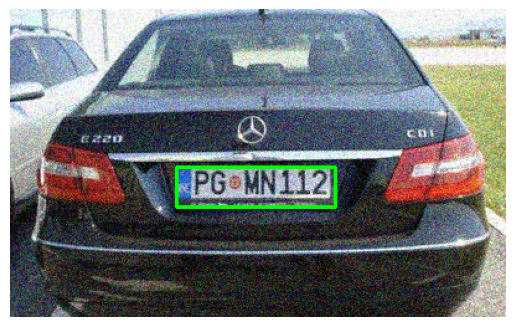

In [36]:
image_dir = '/content/drive/MyDrive/Gaussian_images/train/images'

label_dir = '/content/drive/MyDrive/Gaussian_images/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

# Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height


    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [41]:
# Datasets YAML configuration
datasets_yaml = '''
path: /content/drive/MyDrive/Gaussian_images

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''


# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)


In [38]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]


In [39]:
os.environ['WANDB_MODE'] = 'offline'

In [42]:
# Define the folder where the results will be saved in Google Drive
drive_results_path = '/content/drive/MyDrive/Gaussian_images/yolo_training_results'
# Train the model with noisy images and save results to Google Drive
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True,
    project=drive_results_path,  # Specify the project path in Drive
    name='noisy_model_results',  # Specify the name of the training run
)


Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=/content/drive/MyDrive/Gaussian_images/yolo_training_results, name=noisy_model_results2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

train: Scanning /content/drive/MyDrive/Gaussian_images/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:03<00:00, 86.98it/s] 


train: New cache created: /content/drive/MyDrive/Gaussian_images/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:03<00:00, 95.89it/s] 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Gaussian_images/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 86.93it/s]

val: New cache created: /content/drive/MyDrive/Gaussian_images/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 112.25it/s]


Plotting labels to /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       0.7G      2.275      3.931       1.86          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         44         44    0.00293      0.864     0.0777     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.635G      1.582      2.329      1.382          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         44         44      0.511      0.455      0.525      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.633G      1.694       1.75      1.503          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44      0.649      0.455      0.453      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.631G      1.753       1.56      1.522          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.715      0.591      0.647      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.631G      1.632      1.458      1.486          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

                   all         44         44      0.738      0.578      0.622      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.631G      1.673      1.389      1.473          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]

                   all         44         44      0.642      0.568      0.631      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.631G      1.624      1.327      1.487          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]

                   all         44         44      0.595      0.795      0.715      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.631G      1.551      1.271      1.453          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         44         44      0.564       0.75      0.685      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.631G      1.527      1.246      1.389          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         44         44      0.792      0.682      0.766      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.631G      1.621      1.171      1.438          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         44         44      0.668      0.682        0.7      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.631G      1.583      1.119      1.397          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         44         44        0.9      0.814       0.86      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.631G      1.532      1.077      1.389          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


                   all         44         44      0.803      0.742      0.766      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.631G      1.521      1.075      1.414          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         44         44      0.857      0.795      0.875       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.631G       1.47      1.017       1.31          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]

                   all         44         44      0.865      0.795      0.867       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.631G      1.499     0.9731      1.332          8        320: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         44         44      0.881       0.84      0.877      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.633G       1.53      1.001      1.366          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         44         44      0.814      0.727      0.802       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.631G      1.493     0.9743      1.357          8        320: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         44         44      0.943      0.727       0.86      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.631G      1.477     0.9398      1.337          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.891      0.818      0.843        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.631G      1.404      0.853      1.294          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         44         44      0.857      0.816      0.871      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.631G      1.519     0.8979      1.334          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44      0.857      0.815       0.82      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.629G      1.498     0.9402      1.337          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         44         44      0.845      0.705      0.795      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.631G       1.46     0.8989      1.301          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         44         44      0.907      0.841      0.879      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.631G      1.471     0.8809       1.32          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.67it/s]

                   all         44         44      0.919      0.818      0.889      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.633G      1.381     0.8678      1.263          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         44         44      0.871      0.765      0.878      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.629G      1.386     0.8504      1.282          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         44         44      0.898      0.841      0.865      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.631G      1.399     0.8398      1.267          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

                   all         44         44      0.887      0.892      0.894      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.631G      1.332     0.8252      1.231          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         44         44       0.88      0.836      0.883      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.631G      1.363     0.8213      1.247          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]

                   all         44         44      0.862      0.864      0.879      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.631G      1.317      0.813      1.259          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         44         44       0.86      0.864      0.886      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.631G      1.348     0.8179      1.241          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         44         44       0.95      0.858      0.891      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.629G      1.292     0.7788      1.269          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.17it/s]

                   all         44         44      0.935      0.864      0.929      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.631G      1.314     0.7718      1.262          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.838      0.841      0.874      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.631G      1.376     0.7956      1.259          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44      0.904      0.856      0.909      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.633G       1.36     0.7779      1.286          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         44         44      0.863      0.858      0.838      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.631G       1.31     0.7509      1.252          8        320: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         44         44      0.852      0.841      0.861      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.633G       1.29     0.7576      1.233          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         44         44      0.796      0.889      0.889      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.629G      1.318     0.7676      1.228          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44       0.86      0.864      0.876      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.631G      1.257      0.737      1.236          8        320: 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

                   all         44         44      0.847      0.878      0.872       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.631G      1.284     0.7265      1.244          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         44         44      0.887      0.864      0.873      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.631G      1.253     0.7031       1.22          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         44         44      0.909      0.908      0.906      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.629G       1.25     0.7023      1.215          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.865      0.877      0.885      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.631G      1.266     0.7073      1.224          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]

                   all         44         44      0.882      0.886      0.918      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.631G      1.278     0.7004      1.229          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         44         44      0.833      0.909       0.92      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.631G      1.264     0.7054      1.232          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         44         44      0.943      0.795      0.881      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.629G      1.233     0.6993      1.179          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

                   all         44         44      0.888      0.818       0.89      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.631G      1.305     0.6964      1.232          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         44         44      0.888      0.909      0.909      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.631G      1.224     0.6887      1.185          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44       0.86      0.839      0.868      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.631G      1.208     0.6894       1.19          8        320: 100%|██████████| 22/22 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         44         44      0.925      0.846        0.9      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.629G      1.217     0.6594      1.158          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44       0.95      0.864      0.894      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.631G      1.179     0.6612      1.165          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]

                   all         44         44      0.885      0.886      0.899      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.629G      1.192     0.6544      1.176          8        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]

                   all         44         44      0.879      0.864      0.882      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.631G      1.135     0.6395      1.141          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         44         44      0.915      0.886      0.913       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.631G       1.19     0.6267      1.138          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44      0.927      0.886       0.89      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.631G      1.165     0.6346      1.161          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

                   all         44         44      0.901      0.886      0.885      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.629G      1.149     0.6294       1.16          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.926      0.859      0.901      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.631G      1.156     0.6335      1.146          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]

                   all         44         44      0.903      0.864      0.878      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.631G      1.169       0.62      1.139          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         44         44      0.904      0.855       0.88      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.631G      1.166     0.6079      1.146          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.899      0.841      0.887      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.629G      1.192     0.6134      1.145          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         44         44      0.923      0.812        0.9      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.631G      1.153     0.6153      1.176          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.949      0.841      0.891      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.629G      1.104     0.5996      1.123          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.954      0.841      0.914      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.631G      1.121        0.6      1.129          9        320: 100%|██████████| 22/22 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.24it/s]

                   all         44         44      0.896      0.864      0.904      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.631G      1.079     0.6005      1.111          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         44         44      0.925      0.886      0.904      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.631G      1.117     0.6052      1.142          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         44         44      0.928       0.88      0.902      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.631G      1.109     0.6006      1.139          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]

                   all         44         44       0.94      0.886       0.92      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.631G      1.115     0.5781      1.121          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


                   all         44         44        0.9      0.886      0.926      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.629G      1.065     0.5899      1.085          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         44         44       0.95       0.86      0.919      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.631G      1.072     0.5896      1.082          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         44         44      0.931      0.864      0.927      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.631G      1.113     0.5704      1.107          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         44         44      0.927      0.863      0.904      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.631G       1.08     0.5693      1.091          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]

                   all         44         44      0.886      0.885      0.899      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.631G       1.05     0.5512      1.099          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         44         44      0.904      0.857      0.902      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.631G      1.024     0.5433      1.088          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         44         44      0.922      0.864      0.899      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.631G      1.035     0.5614      1.099          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         44         44      0.922      0.864      0.895      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.631G      1.047     0.5655       1.11          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.928      0.879      0.884      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.629G      1.008     0.5525      1.063          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.905      0.886      0.881      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.631G      1.047     0.5481      1.094          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]

                   all         44         44      0.892      0.886      0.883      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.631G      1.053     0.5383      1.096          9        320: 100%|██████████| 22/22 [00:03<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

                   all         44         44      0.882      0.886      0.893      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.633G      1.048      0.542      1.077          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         44         44      0.901      0.824      0.881      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.631G      1.052     0.5485      1.101          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44       0.86      0.886       0.88      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.631G      1.034      0.553      1.103          8        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44      0.866      0.886       0.88      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.631G      1.012     0.5268      1.065          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


                   all         44         44      0.928      0.875      0.897      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.631G     0.9851     0.5295      1.066          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.68it/s]

                   all         44         44      0.952      0.864      0.904      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.631G     0.9482     0.5132       1.05          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         44         44      0.911      0.818      0.897       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.631G     0.9912     0.5112      1.048          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         44         44      0.906      0.818      0.897      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.631G     0.9594     0.4961      1.025          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]

                   all         44         44       0.92      0.886      0.888      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.631G     0.9812     0.5223      1.056          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.928      0.885      0.894      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.631G      1.004      0.517      1.063          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         44         44      0.907      0.883      0.892      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.631G     0.9679     0.4937      1.068          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         44         44      0.901      0.886       0.89      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.631G     0.9456     0.4995      1.068          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         44         44      0.919      0.886      0.887       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.631G      0.953     0.5032      1.049          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         44         44      0.926      0.857       0.88      0.564


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.631G     0.9617     0.4991      1.023          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

                   all         44         44      0.906      0.878      0.888       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.631G     0.9505     0.4974       1.05          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         44         44      0.928      0.882      0.885      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.631G     0.9411     0.4889      1.043          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         44         44      0.911      0.864      0.884      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.631G     0.9112     0.4864      1.031          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.904      0.886      0.881      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.631G     0.8901     0.4662       1.04          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         44         44      0.903      0.886      0.881      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.631G     0.9319     0.4905      1.028          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         44         44      0.902      0.886       0.88      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.631G     0.8978     0.4741      1.032          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         44         44      0.903      0.886       0.88      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.631G     0.8842     0.4766      1.026          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         44         44      0.899      0.886      0.879      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.631G     0.8621     0.4699      1.025          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

                   all         44         44        0.9      0.886      0.881      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.633G     0.8785     0.4868      1.014          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         44         44        0.9      0.886      0.879      0.557



100 epochs completed in 0.122 hours.
Optimizer stripped from /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


                   all         44         44      0.953      0.864      0.904      0.569
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/drive/MyDrive/Gaussian_images/yolo_training_results/noisy_model_results2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dff1a6af8e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

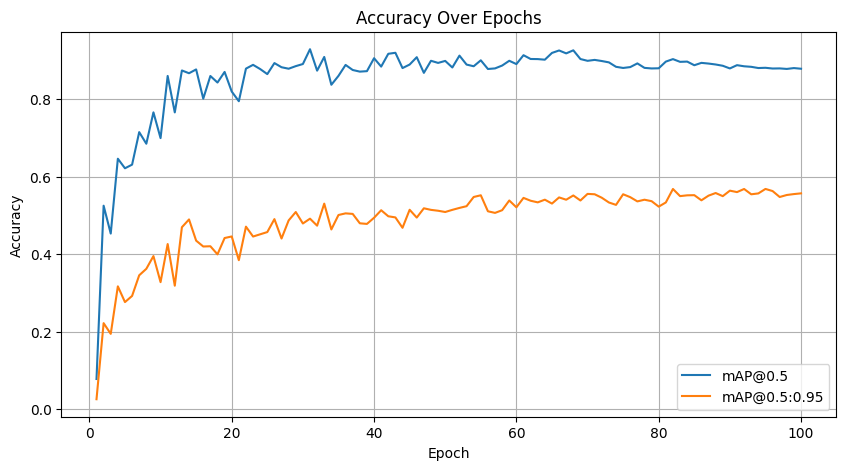

In [43]:
# Get the path of the log directory in Google Drive
log_dir = max(glob(f'{drive_results_path}/noisy_model_results*'), key=os.path.getctime)

# Read the training results from the saved CSV in Google Drive
results_csv_path = os.path.join(log_dir, 'results.csv')
results = pd.read_csv(results_csv_path)
results.columns = results.columns.str.strip()

# Extract epochs and mAP metrics
epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Save the trained model in Google Drive
model.save('/content/drive/MyDrive/Gaussian_images/license_plate_model_with_gaussian_noise.pt')

In [45]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars0.png: 192x320 1 license_plate, 44.6ms
Speed: 1.3ms preprocess, 44.6ms inference, 18.3ms postprocess per image at shape (1, 3, 192, 320)


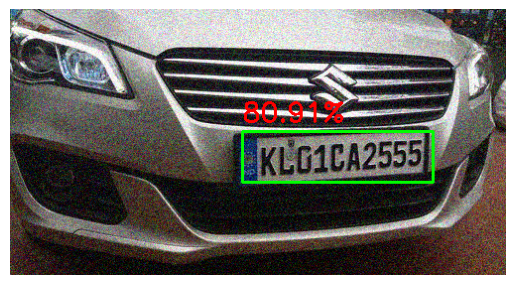

In [47]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars0.png')


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars106.png: 224x320 1 license_plate, 68.7ms
Speed: 1.2ms preprocess, 68.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


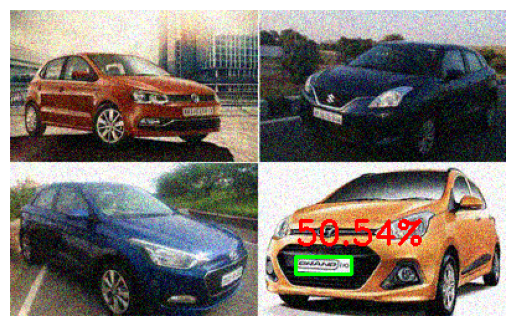

In [49]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars106.png')


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars172.png: 320x320 1 license_plate, 98.5ms
Speed: 1.6ms preprocess, 98.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


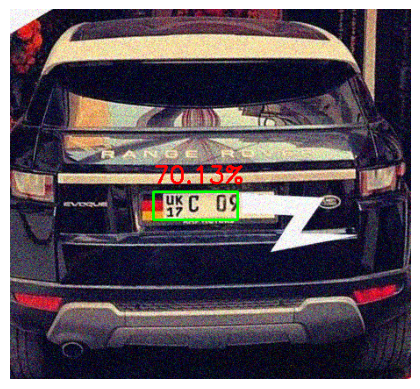

In [50]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars172.png')


image 1/1 /content/drive/MyDrive/Gaussian_images/val/images/Cars246.png: 224x320 1 license_plate, 79.0ms
Speed: 1.2ms preprocess, 79.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)


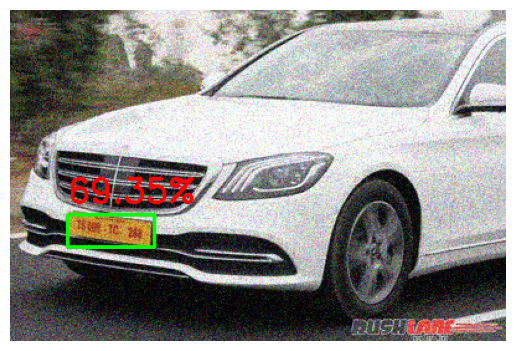

In [52]:
predict_and_plot('/content/drive/MyDrive/Gaussian_images/val/images/Cars246.png')